In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import Utils
import folium
from folium.plugins import HeatMap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

##### First let's look at some empirical data measured by Louisville metro government

In [322]:
df_emp = pd.read_csv("./datasets/louisville_air_quality_empirical.csv")

In [323]:
df_emp

,Site Name,2018,2019,2020,2021,2022,2023,2024
0,Algonquin,9.6,9.1,8.1,9.0,7.9,9.6,7.9
1,Durrett Lane,10.1,9.6,8.8,9.9,8.4,10.2,7.9
2,Cannons Lane,8.9,8.4,7.9,8.7,7.3,9.1,7.2
3,Carrithers,NaN,8.4,7.9,8.8,7.9,9.5,7.3
4,Watson Lane,10.3,9.1,8.8,9.4,8.5,9.9,8.0
5,Jeffersonville,9.2,8.5,8.8,9.9,9.1,10.5,8.4
6,New Albany,NaN,NaN,NaN,NaN,NaN,8.4,6.5


In [324]:
years = list(df_emp.columns[1:])

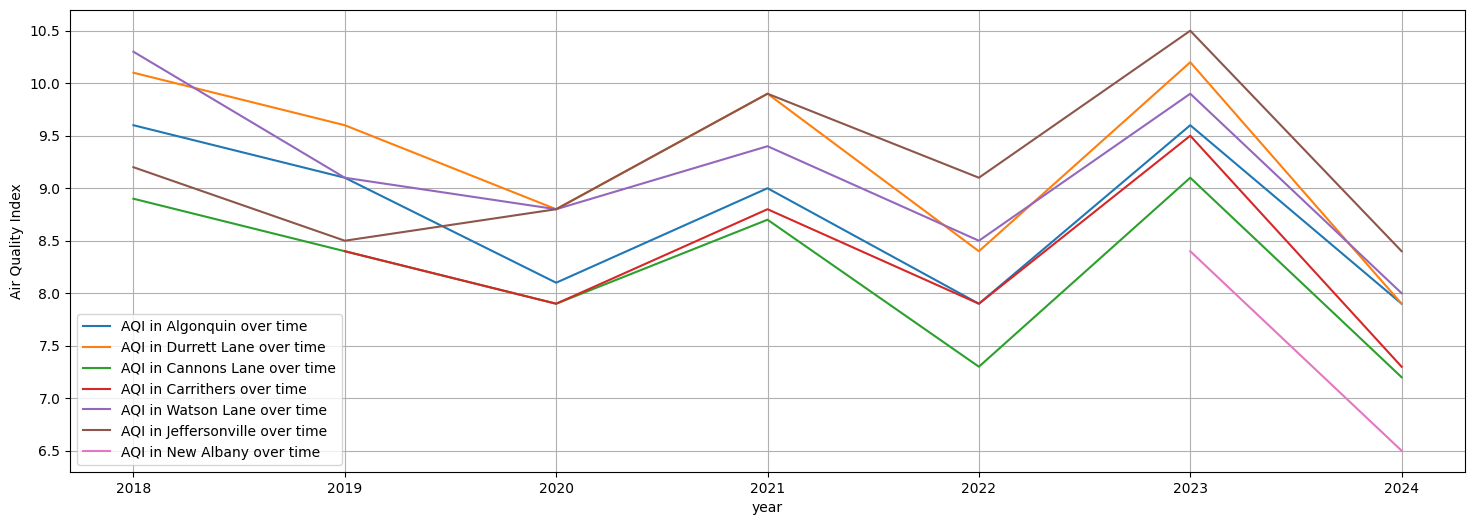

In [325]:
plt.figure(figsize=(18,6))
sites = df_emp["Site Name"]
for site in sites:
    data = list(df_emp[df_emp["Site Name"] == site].iloc[0, 1:])
    plt.plot(years, data, label="AQI in {} over time".format(site))
    plt.xlabel("year")
    plt.ylabel("Air Quality Index")
    plt.legend()
    plt.grid()

##### Now, let's look at the raw data we measured across louisville

In [326]:
df_meas = pd.read_csv("./datasets/Louisville pollution - air quality measurements.csv")

df_meas.head(5)

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction)
0,Rubber town (W),38.21197 N 85.84051 W,12:15 PM 12/8/2024,450.0,0.190,0.130,53.0,0.29
1,Louisville Airport(S),38.18604 N 85.74339 W,11:58 AM 12/8/2024,405.0,0.020,0.008,52.0,0.36
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405.0,0.020,0.006,39.0,0.20
3,Flat rock road (E),38.26705 N 85.44206 W,3:30 PM 12/7/2024,416.0,0.015,0.005,41.0,0.20
4,Prospect (N),38.24171 N 85.84051 W,12:52 PM 12/8/2024,424.0,0.015,0.010,54.0,0.31


##### We need to construct a measure of air quality using our formeldahyde, CO2, and TVOC that is comparable to the AQI from the empirical data

In [327]:
jtown_df = df_meas.query("Area == 'Jeffersontown (SE)'")
jtown_df

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction)
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405.0,0.020,0.006,39.0,0.2
9,Jeffersontown (SE),38.18644 N 85.56063 W,2:30 PM 12/14/2024,500.0,0.047,0.014,53.0,0.4
16,Jeffersontown (SE),38.18664 N 85.56013 W,3:10 PM 12/22/2024,412.0,0.021,0.014,34.0,0.2


To convert ppm (parts per million) to g/m3 (grams per cubic meter), you need to multiply the ppm value by the molecular weight of the substance and divide by the molar volume of a gas at standard conditions (approximately 24.45 liters per mole), resulting in the concentration in g/m3: g/m3 = (ppm * Molecular Weight) / 24.45.

In [328]:
# compute volume that air monitor measures in meters
monitor_volume = (100 * 69 * 35) * (10 ** -3) ** 3

In [329]:
def ppm_to_mg_monitor(ppm, molar_mass, volume):
    return ((ppm * molar_mass) / 24.45) * volume

In [330]:
jtown_df["CO2 (mg)"] = jtown_df['CO2 (ppm)'].apply(ppm_to_mg_monitor, args=(44.01, 0.00024150000000000002,))

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_33676/3015964343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jtown_df["CO2 (mg)"] = jtown_df['CO2 (ppm)'].apply(ppm_to_mg_monitor, args=(44.01, 0.00024150000000000002,))


In [331]:
jtown_df

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),CO2 (mg)
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405.0,0.020,0.006,39.0,0.2,0.176054
9,Jeffersontown (SE),38.18644 N 85.56063 W,2:30 PM 12/14/2024,500.0,0.047,0.014,53.0,0.4,0.217350
16,Jeffersontown (SE),38.18664 N 85.56013 W,3:10 PM 12/22/2024,412.0,0.021,0.014,34.0,0.2,0.179096


##### We need our air quality coefficient to be ~6.5-8.5

##### Using weights of [0.4, 0.3, 0.3] for the CO2, formeldahyde, and TVOC respectively, we get an AQ coefficient on the same order of magnitude as the empirical AQI

In [332]:
jtown_df["AQ computed coeff"] = 100 * 0.4 * jtown_df["CO2 (mg)"] + 0.3 * jtown_df["HCHO (Formaldehyde) (mg)"] + 0.3 * jtown_df["TVOC (Total Volatile Organic compounds) (mg)"]

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_33676/4158118521.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jtown_df["AQ computed coeff"] = 100 * 0.4 * jtown_df["CO2 (mg)"] + 0.3 * jtown_df["HCHO (Formaldehyde) (mg)"] + 0.3 * jtown_df["TVOC (Total Volatile Organic compounds) (mg)"]


In [333]:
jtown_df

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),CO2 (mg),AQ computed coeff
2,Jeffersontown (SE),38.18642 N 85.56060 W,6:30 PM 12/7/2024,405.0,0.020,0.006,39.0,0.2,0.176054,7.049940
9,Jeffersontown (SE),38.18644 N 85.56063 W,2:30 PM 12/14/2024,500.0,0.047,0.014,53.0,0.4,0.217350,8.712300
16,Jeffersontown (SE),38.18664 N 85.56013 W,3:10 PM 12/22/2024,412.0,0.021,0.014,34.0,0.2,0.179096,7.174356


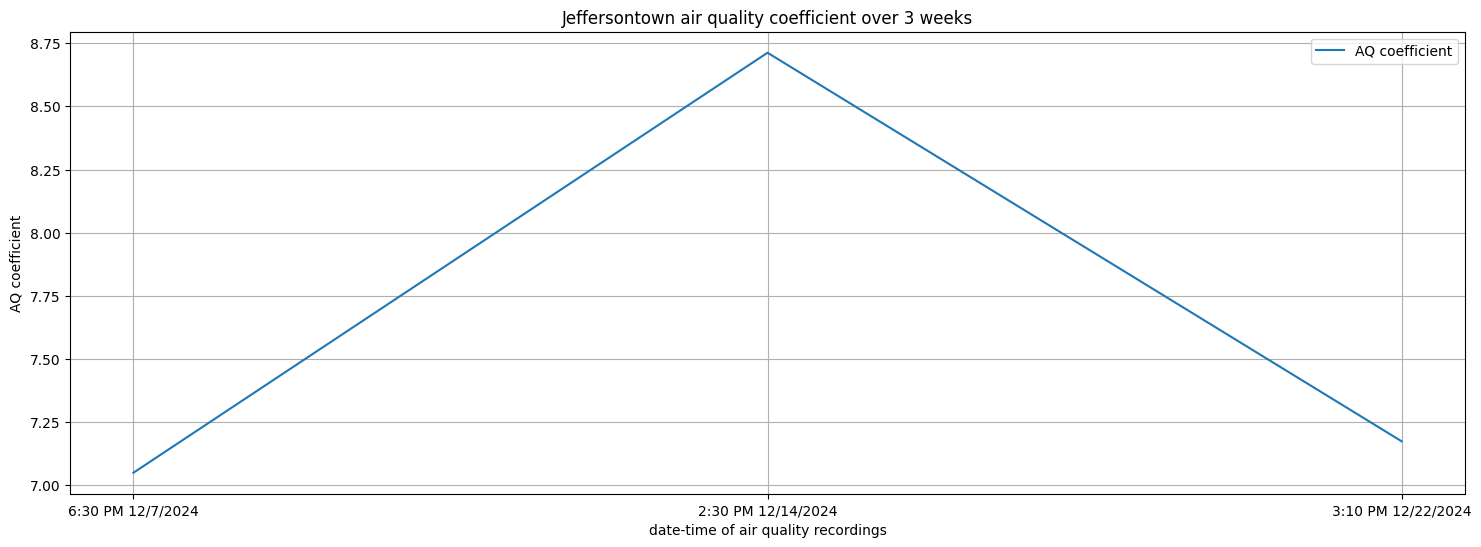

In [334]:
plt.figure(figsize=(18,6))
plt.plot(jtown_df["Time/Date"], jtown_df["AQ computed coeff"], label = "AQ coefficient")
plt.xlabel("date-time of air quality recordings")
plt.ylabel("AQ coefficient")
plt.title("Jeffersontown air quality coefficient over 3 weeks")
plt.legend()
plt.grid()

##### This isn't enough data points to forecast, let's cluster locations into western cluster, central cluster, eastern cluster based on proximity 

In [335]:
df_meas["loc_clusters"] = [0, 1, 2, 2, 0, 1, 1, 0, 1, 2, 2, 0, 1, 1, 0, 1, 2, 2, 0, 1, 1]

df_meas[["Area", "loc_clusters"]].head(7) 

,Area,loc_clusters
0,Rubber town (W),0
1,Louisville Airport(S),1
2,Jeffersontown (SE),2
3,Flat rock road (E),2
4,Prospect (N),0
5,Mid-town,1
6,Downtown Meyzeek,1


Cluster 0: Western,
Cluster 1: Central,
Cluster 2: Eastern

##### We know our AQ coefficient model is accurate now, let's apply it to all of the areas

In [336]:
df_meas["CO2 (mg)"] = df_meas['CO2 (ppm)'].apply(ppm_to_mg_monitor, args=(44.01, monitor_volume,))
df_meas["AQ computed coeff"] = 100 * 0.4 * df_meas["CO2 (mg)"] + 0.3 * df_meas["HCHO (Formaldehyde) (mg)"] + 0.3 * df_meas["TVOC (Total Volatile Organic compounds) (mg)"]
df_meas["Time/Date"] = pd.to_datetime(df_meas["Time/Date"], format="%I:%M %p %m/%d/%Y")
df_meas = df_meas.sort_values(by="Time/Date")

In [337]:
df_meas.head(1)

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQ computed coeff
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416.0,0.015,0.005,41.0,0.2,2,0.180835,7.239408


In [338]:
df_west = df_meas.query("loc_clusters == 0")
df_west = df_west.dropna()

df_cent = df_meas.query("loc_clusters == 1")
df_cent = df_cent.dropna()

df_east = df_meas.query("loc_clusters == 2")
df_east = df_east.dropna()


In [339]:
df_east

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQ computed coeff
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416.0,0.015,0.005,41.0,0.20,2,0.180835,7.239408
2,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-07 18:30:00,405.0,0.020,0.006,39.0,0.20,2,0.176054,7.049940
9,Jeffersontown (SE),38.18644 N 85.56063 W,2024-12-14 14:30:00,500.0,0.047,0.014,53.0,0.40,2,0.217350,8.712300
16,Jeffersontown (SE),38.18664 N 85.56013 W,2024-12-22 15:10:00,412.0,0.021,0.014,34.0,0.20,2,0.179096,7.174356
17,Flat rock road (E),38.26714 N 85.44216 W,2024-12-22 15:32:00,542.0,0.068,0.012,34.0,0.27,2,0.235607,9.448296


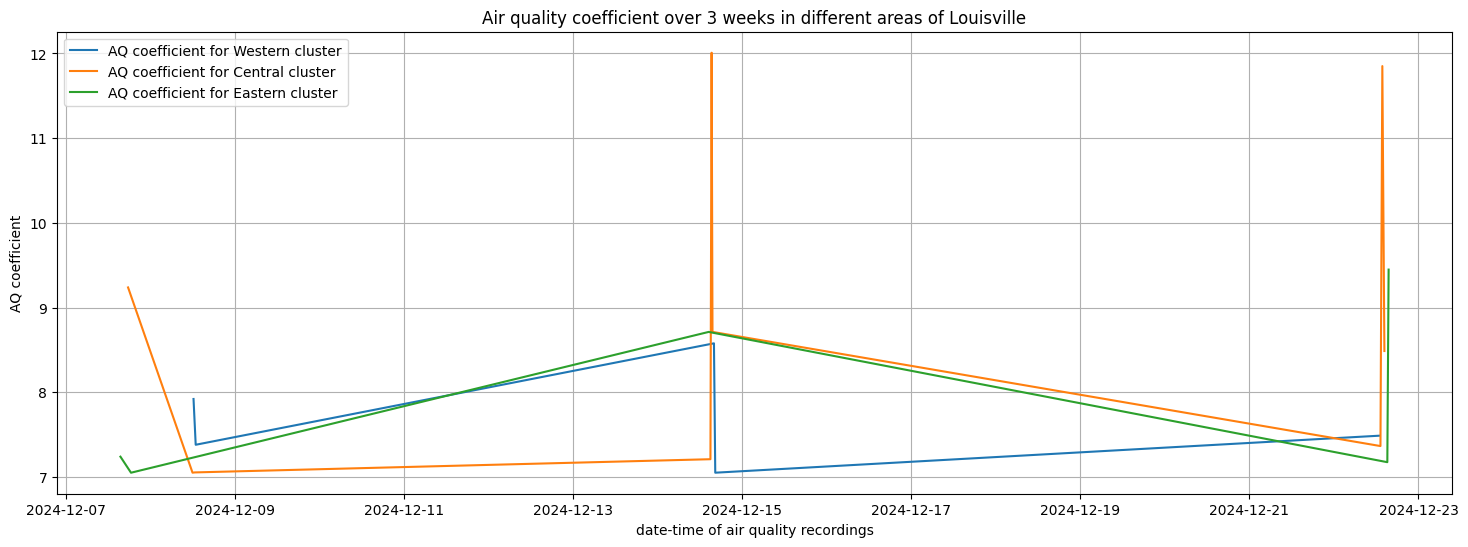

In [340]:
plt.figure(figsize=(18,6))
plt.plot(df_west["Time/Date"], df_west["AQ computed coeff"], label = "AQ coefficient for Western cluster")
plt.plot(df_cent["Time/Date"], df_cent["AQ computed coeff"], label = "AQ coefficient for Central cluster")
plt.plot(df_east["Time/Date"], df_east["AQ computed coeff"], label = "AQ coefficient for Eastern cluster")
plt.xlabel("date-time of air quality recordings")
plt.ylabel("AQ coefficient")
plt.title("Air quality coefficient over 3 weeks in different areas of Louisville")
plt.legend()
plt.grid()

##### This gives our plot a lot of discontinuities, let's try doing the average of the locations on a given day to get a nicer looking plot

In [341]:
df_west["Date"] = df_west["Time/Date"].dt.date
df_days_west = df_west.groupby("Date")["AQ computed coeff"].mean().reset_index()
df_days_west.columns = ["Date", "Average AQ Coefficient"]

df_cent["Date"] = df_cent["Time/Date"].dt.date
df_days_cent = df_cent.groupby("Date")["AQ computed coeff"].mean().reset_index()
df_days_cent.columns = ["Date", "Average AQ Coefficient"]

df_east["Date"] = df_east["Time/Date"].dt.date
df_days_east = df_east.groupby("Date")["AQ computed coeff"].mean().reset_index()
df_days_east.columns = ["Date", "Average AQ Coefficient"]

##### Let's plot as histograms since we don't have sequential time data anymore

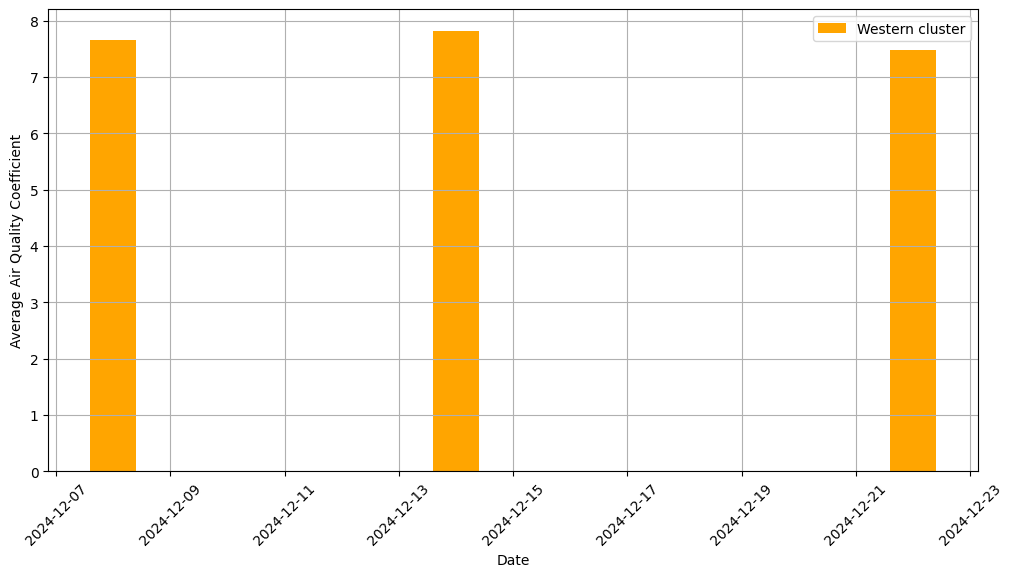

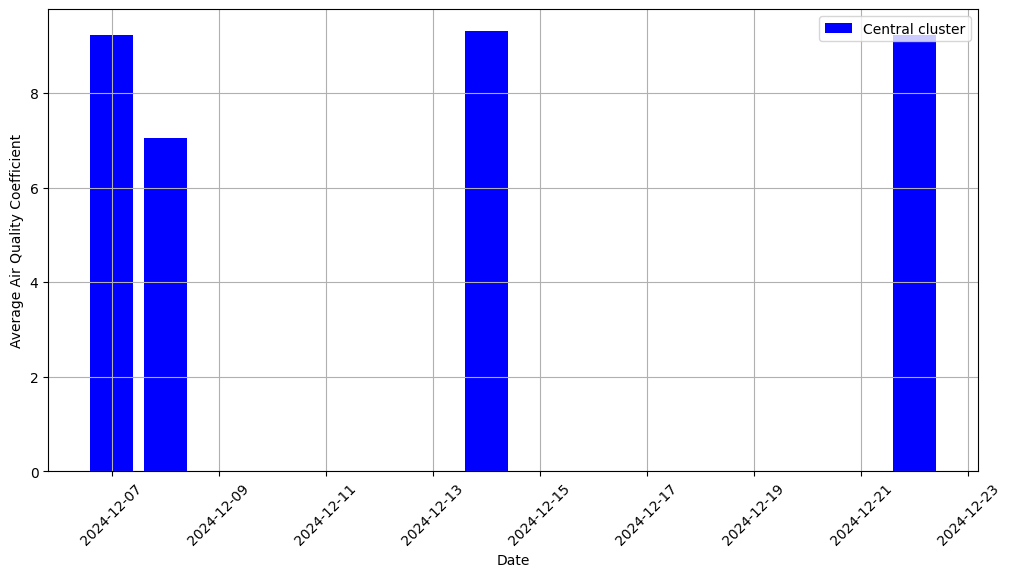

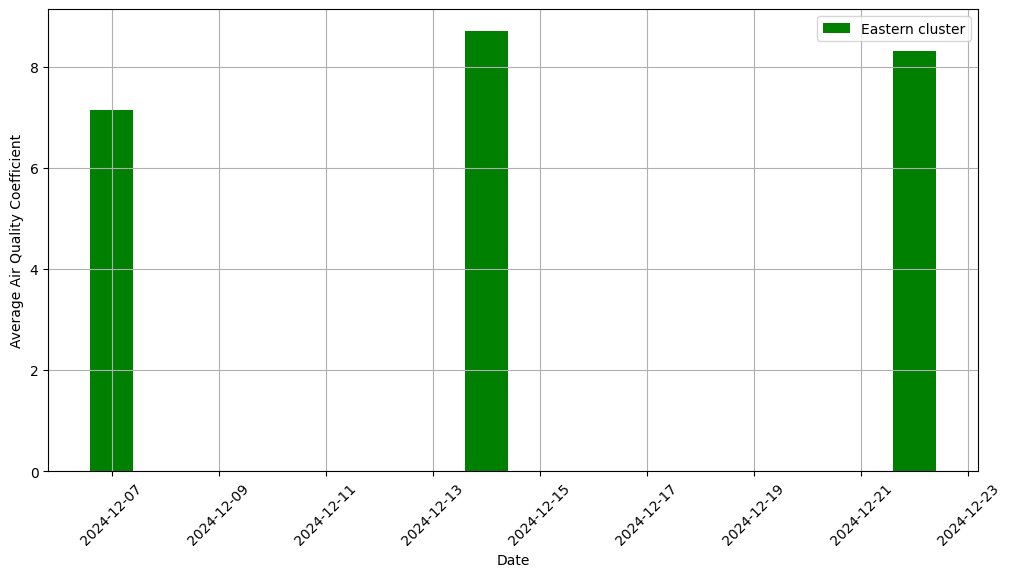

In [342]:
plt.figure(figsize=(12, 6))
plt.bar(
    df_days_west["Date"], 
    df_days_west["Average AQ Coefficient"],
    color="orange",
    label="Western cluster"
)
plt.xlabel("Date")
plt.ylabel("Average Air Quality Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.bar(
    df_days_cent["Date"], 
    df_days_cent["Average AQ Coefficient"],
    color="Blue",
    label="Central cluster"
)
plt.xlabel("Date")
plt.ylabel("Average Air Quality Coefficient")
plt.xticks(rotation=45)
plt.legend()
plt.grid()

plt.figure(figsize=(12, 6))
plt.bar(
    df_days_east["Date"], 
    df_days_east["Average AQ Coefficient"],
    color="Green",
    label="Eastern cluster"
)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Average Air Quality Coefficient")
plt.legend()
plt.grid()



##### Using an average makes this looks relatively uniform, let's try creating a heat map

In [343]:
df_map = df_meas.dropna()
df_map

,Area,Coordinates,Time/Date,CO2 (ppm),TVOC (Total Volatile Organic compounds) (mg),HCHO (Formaldehyde) (mg),Temperature (Degrees F),Air humidity (fraction),loc_clusters,CO2 (mg),AQ computed coeff
3,Flat rock road (E),38.26705 N 85.44206 W,2024-12-07 15:30:00,416.0,0.015,0.005,41.0,0.20,2,0.180835,7.239408
5,Mid-town,38.18888 N 85.64317 W,2024-12-07 17:40:00,530.0,0.062,0.011,40.0,0.60,1,0.230391,9.237540
2,Jeffersontown (SE),38.18642 N 85.56060 W,2024-12-07 18:30:00,405.0,0.020,0.006,39.0,0.20,2,0.176054,7.049940
1,Louisville Airport(S),38.18604 N 85.74339 W,2024-12-08 11:58:00,405.0,0.020,0.008,52.0,0.36,1,0.176054,7.050540
0,Rubber town (W),38.21197 N 85.84051 W,2024-12-08 12:15:00,450.0,0.190,0.130,53.0,0.29,0,0.195615,7.920600
6,Downtown Meyzeek,38.24171 N 85.74769 W,2024-12-08 12:36:00,405.0,0.026,0.012,54.0,0.39,1,0.176054,7.053540
4,Prospect (N),38.24171 N 85.84051 W,2024-12-08 12:52:00,424.0,0.015,0.010,54.0,0.31,0,0.184313,7.380012
9,Jeffersontown (SE),38.18644 N 85.56063 W,2024-12-14 14:30:00,500.0,0.047,0.014,53.0,0.40,2,0.217350,8.712300
12,Mid-town,38.188869 N 85.64313 W,2024-12-14 15:00:00,414.0,0.022,0.014,53.0,0.24,1,0.179966,7.209432
8,Louisville Airport(S),38.1608 N 85.74257 W,2024-12-14 15:20:00,689.0,0.074,0.021,52.0,0.30,1,0.299508,12.008832


In [344]:
def parse_coordinates(coord):
    lat, lon = coord.split(" N ")[0], coord.split(" N ")[1].replace(" W", "")
    return float(lat), -float(lon)

In [345]:
df_map["Latitude"], df_map["Longitude"] = zip(*df_map["Coordinates"].apply(parse_coordinates))

map_center = [df_map["Latitude"].mean(), df_map["Longitude"].mean()]
air_quality_map = folium.Map(location=map_center, zoom_start=12)
heat_data = [[row["Latitude"], row["Longitude"], row["AQ computed coeff"]] for _, row in df_map.iterrows()]
HeatMap(heat_data, radius=15, max_zoom=13).add_to(air_quality_map)


air_quality_map.save("AQ_heatmap_lou.html")
air_quality_map

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_33676/1723625251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map["Latitude"], df_map["Longitude"] = zip(*df_map["Coordinates"].apply(parse_coordinates))
/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_33676/1723625251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_map["Latitude"], df_map["Longitude"] = zip(*df_map["Coordinates"].apply(parse_coordinates))


##### We've done some EDA on our findings, now let's look at using these findings as arguments to a linear model so we can forecast the AQ. We will use raw data from [SOURCE] to construct a linear model and then project into the future and see which has the worst air quality.

##### Using US AQI data from the EPA, let's build our linear model for Louisville

In [346]:
df_us = pd.read_csv("./datasets/US_AQI.csv")

In [347]:
df_ky = df_us.query("state_name == 'Kentucky'")
df_ky.head(5)

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
2694,2753,14540,2022-01-01,30,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2695,2754,14540,2022-01-02,30,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2696,2755,14540,2022-01-03,33,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2697,2756,14540,2022-01-04,29,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago
2698,2757,14540,2022-01-05,32,Good,Ozone,1,Bowling Green,KY,Kentucky,36.9716,-86.4378,94555.0,684.0,America/Chicago


In [348]:
print(df_ky["city_ascii"].unique())

['Bowling Green' 'Elizabethtown' 'Lexington' 'Middlesborough' 'Owensboro'
 'Paducah' 'Somerset' 'Richmond' 'Frankfort' 'London' 'Mayfield'
 'Central City' 'Maysville' 'Glasgow' 'Madisonville' 'Murray' 'Danville']


##### It looks like there isn't data for Louisville specifically, so let's model using lexington data

In [349]:
df_lex = df_ky.query("city_ascii == 'Lexington'")

In [350]:
df_lex["Date"] = pd.to_datetime(df_lex["Date"])
df_lex = df_lex.sort_values(by="Date")

/var/folders/_s/gyy2hzx57s90tk86zfdrv0p40000gn/T/ipykernel_33676/1208013094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lex["Date"] = pd.to_datetime(df_lex["Date"])


In [355]:
df_lex.head(5)

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
5575078,5675074,30460,1980-01-01,11,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575079,5675075,30460,1980-01-02,23,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575080,5675076,30460,1980-01-03,23,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575081,5675077,30460,1980-01-04,25,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
5575082,5675078,30460,1980-01-05,30,Good,NO2,2,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York


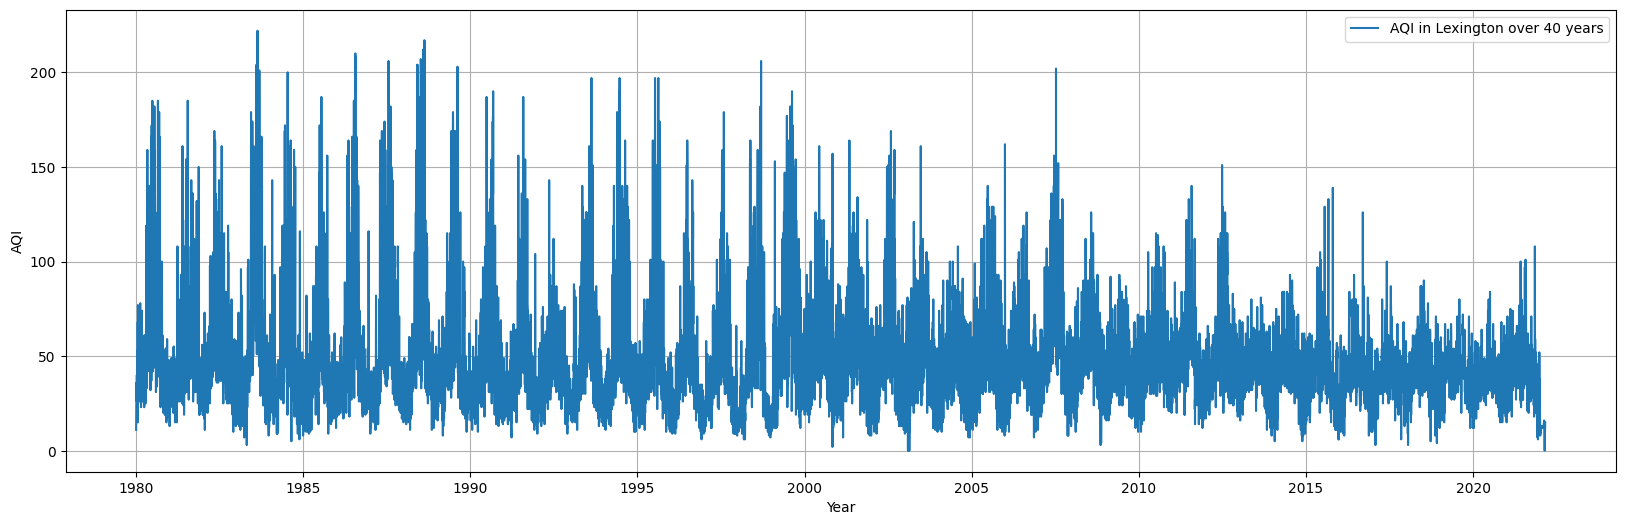

In [391]:
plt.figure(figsize=(20,6))
plt.plot(df_lex["Date"], df_lex["AQI"], label="AQI in Lexington over 40 years")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Plotting a heat map so we can interpret this a bit

In [357]:
map_center = [df_lex["lat"].mean(), df_lex["lng"].mean()]
air_quality_map = folium.Map(location=map_center, zoom_start=12)
heat_data = [[row["lat"], row["lng"], row["AQI"]] for _, row in df_lex.iterrows()]
HeatMap(heat_data, radius=15, max_zoom=13).add_to(air_quality_map)


air_quality_map.save("AQ_heatmap_lex.html")
air_quality_map

##### Looks like these lexington recordings are only taken at one AQ monitor, but this should suffice for a linear model

##### Let's chunk our data into years so we can avoid overfitting

In [397]:
df_2014 = df_lex[df_lex["Date"].dt.year == 2014]
df_2015 = df_lex[df_lex["Date"].dt.year == 2015]
df_2016 = df_lex[df_lex["Date"].dt.year == 2016]
df_2014.head(5)

,Unnamed: 0,CBSA Code,Date,AQI,Category,Defining Parameter,Number of Sites Reporting,city_ascii,state_id,state_name,lat,lng,population,density,timezone
1285518,1309272,30460,2014-01-01,25,Good,NO2,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285519,1309273,30460,2014-01-02,37,Good,PM2.5,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285520,1309274,30460,2014-01-03,21,Good,NO2,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285521,1309275,30460,2014-01-04,12,Good,PM2.5,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York
1285522,1309276,30460,2014-01-05,27,Good,PM2.5,1,Lexington,KY,Kentucky,38.0423,-84.4587,316743.0,438.0,America/New_York


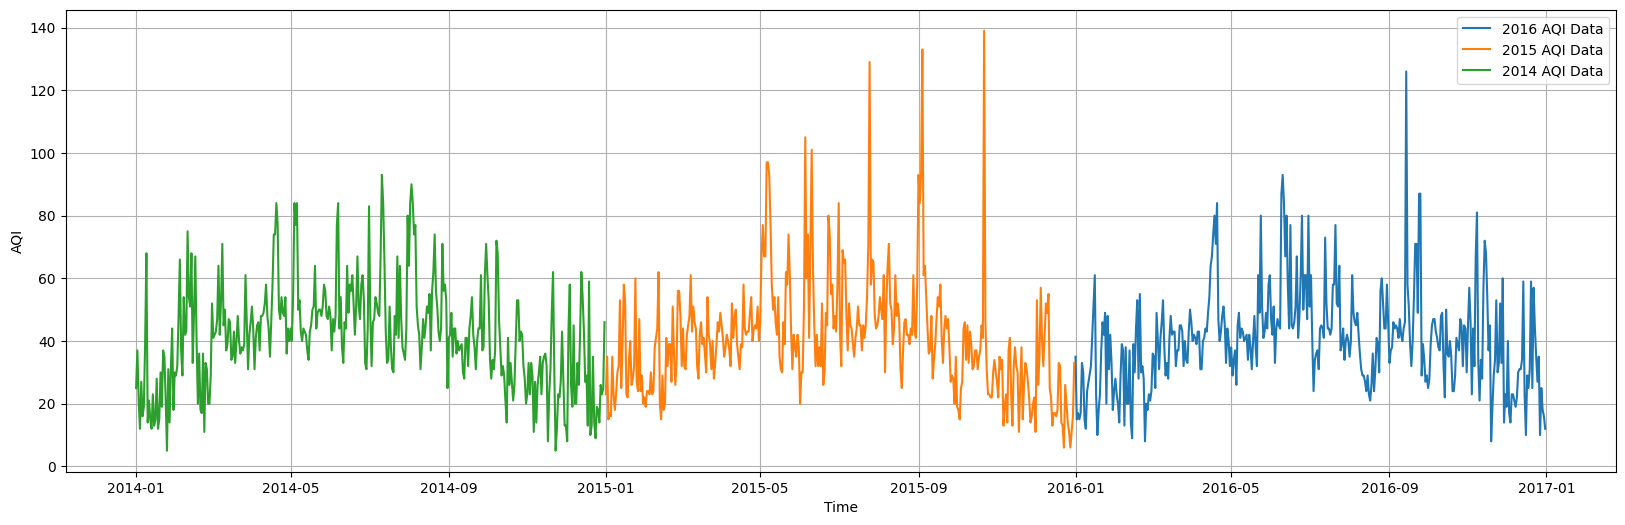

In [398]:
plt.figure(figsize=(20,6))
plt.plot(df_2016["Date"], df_2016["AQI"], label="2016 AQI Data")
plt.plot(df_2015["Date"], df_2015["AQI"], label="2015 AQI Data")
plt.plot(df_2014["Date"], df_2014["AQI"], label="2014 AQI Data")
plt.xlabel("Time")
plt.ylabel("AQI")
plt.grid()
plt.legend()

##### Each year shows roughly the same behavior so we can train on each eyar (ie train test split 80/20)

##### Let's reformat the date in a year to a day 1-365

In [426]:
X = np.array([i for i in range(365)])
y = np.array(list(df_2014["AQI"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train.reshape(-1,1), y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

ValueError: Expected 2D array, got 1D array instead:
array=[292  65 103 252 152  46  62  44 211 157 200  13 306  23 178 165 123  18
  43 259 346  74   8  91  37 145 167 194  39 128 224 324 205  92 312 273
 150 359 328 283  51 121 101 170 108  77 192 217  48 348   1 203 149 117
 169  34 255  78 141 287 284  97 214 316 172 201 182  12 100   3 134 267
 294].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.